# 🧠 Model Selection

The car insurance claim prediction task is a supervised classification problem with a binary target (0 = no claim, 1 = claim). Since the target is discrete, classification not regression is appropriate. The goal is to predict whether a policyholder will make a claim using labeled data and various classification algorithms.

Suitable Classification Models:
  * Linear Models: Logistic Regression, Ridge Classifier, SGD Classifier
  * Support Vector Machines: SVC, LinearSVC
  * Tree-based Models: Decision Tree, Random Forest, Extra Trees, Gradient Boosting, XGBoost, LightGBM, CatBoost
  * Naive Bayes: GaussianNB, BernoulliNB
  * KNN: KNeighborsClassifier

Among feature selection methods, Mutual Information (MI) was found to be the most effective,making it the preferred choice for identifying important features in this task.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt # Plot bar chart with values
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

import sys
import os

# Set paths
sys.path.append(r'E:\USW\Project\car_insurance_claim_prediction\src')
os.chdir(r'E:\USW\Project\car_insurance_claim_prediction\notebooks')

import importlib
import model_selection as mt

# Reload if the module was modified
importlib.reload(mt)

<module 'model_selection' from 'E:\\USW\\Project\\car_insurance_claim_prediction\\src\\model_selection.py'>

## 1. 🔽 Load data 

In [2]:
# Load training data
train_df = pd.read_csv('../data/processed/cleaned_train_data.csv')
print(train_df['is_claim'].value_counts(normalize=True))

is_claim
0.0    0.936032
1.0    0.063968
Name: proportion, dtype: float64


## 2. 🔎Feature Selection
Based on best methods Mutual Information (MI) 

In [3]:
# Feature Selection
selected_features = mt.load_selected_features('../outputs/mi_features.csv')
print(f"Loaded selected features: {selected_features}")

train_df = train_df[selected_features + ['is_claim']]


Loaded selected features: ['transmission_type', 'is_front_fog_lights', 'is_day_night_rear_view_mirror', 'is_central_locking', 'is_power_steering', 'steering_type', 'is_brake_assist', 'is_speed_alert', 'is_driver_seat_height_adjustable', 'is_adjustable_steering', 'rear_brakes_type', 'is_parking_sensors', 'is_power_door_locks', 'cylinder', 'is_ecw', 'policy_tenure', 'area_cluster', 'population_density', 'age_of_car', 'age_of_policyholder']


## 3. ⚖️ Handle Class Imbalance

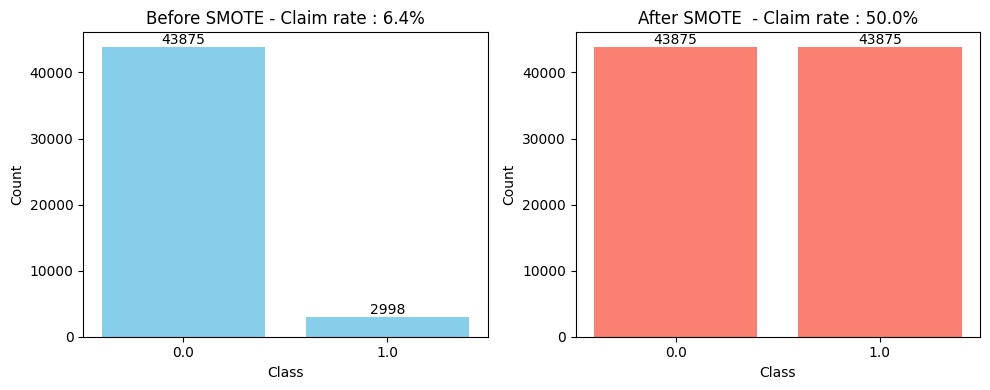

In [4]:
# Split data
X_train, X_val, y_train, y_val = mt.split_data(train_df, target_column='is_claim')

# Count before SMOTE
before_counts = y_train.value_counts().sort_index()
before_total = before_counts.sum()
before_percent = (before_counts / before_total * 100).round(2)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Count after SMOTE
after_counts = pd.Series(y_train_smote).value_counts().sort_index()
after_total = after_counts.sum()
after_percent = (after_counts / after_total * 100).round(2)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Before SMOTE
axes[0].bar(before_counts.index.astype(str), before_counts.values, color='skyblue')
for i, val in enumerate(before_counts.values):
    axes[0].text(i, val + 10, f'{val}', ha='center', va='bottom', fontsize=10)
axes[0].set_title(f"Before SMOTE - Claim rate : {before_percent[1]}%")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# After SMOTE
axes[1].bar(after_counts.index.astype(str), after_counts.values, color='salmon')
for i, val in enumerate(after_counts.values):
    axes[1].text(i, val + 10, f'{val}', ha='center', va='bottom', fontsize=10)
axes[1].set_title(f"After SMOTE  - Claim rate : {after_percent[1]}%")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


## 4. 📊 Get All Classifiers

In [5]:
print("Class Distribution:")
print(train_df['is_claim'].value_counts(normalize=True))

# To compute scale_pos_weight for boosting models
positive = train_df['is_claim'].sum()
negative = len(train_df) - positive
scale = negative / positive
print(f"scale_pos_weight = {scale:.2f}")

# Print class distribution and scale for imbalance
models = mt.get_models()
print(f"Classifiers: {models}")
models['XGBoost'].set_params(scale_pos_weight=scale)
models['LightGBM'].set_params(scale_pos_weight=scale)



Class Distribution:
is_claim
0.0    0.936032
1.0    0.063968
Name: proportion, dtype: float64
scale_pos_weight = 14.63
Classifiers: {'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 'Ridge Classifier': RidgeClassifier(class_weight='balanced'), 'SGD Classifier': SGDClassifier(class_weight='balanced', random_state=42), 'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42), 'Gradient Boosting': GradientBoostingClassifier(random_state=42), 'Extra Trees': ExtraTreesClassifier(random_state=42), 'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42), 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
  

LGBMClassifier(class_weight='balanced', random_state=42,
               scale_pos_weight=np.float64(14.632870864461045))

## 5. 🏋️ Evaluate the model

In [6]:
# Evaluate models
results = mt.evaluate_all_models(models, X_train, X_val, y_train, y_val)

[LightGBM] [Info] Number of positive: 2998, number of negative: 43875
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 46873, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


## 6. ✅ Display Results 

In [7]:
results = results.sort_values(by='ROC AUC', ascending=False)
display(results)

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Confusion Matrix
Gradient Boosting,0.935745,0.2,0.001333,0.002649,0.655051,"[[10965, 4], [749, 1]]"
LightGBM,0.205308,0.070519,0.937333,0.131169,0.638566,"[[1703, 9266], [47, 703]]"
CatBoost,0.663879,0.098464,0.521333,0.165643,0.632466,"[[7389, 3580], [359, 391]]"
XGBoost,0.694172,0.09305,0.432,0.153119,0.614814,"[[7811, 3158], [426, 324]]"
SVC,0.533237,0.079922,0.598667,0.141018,0.593125,"[[5800, 5169], [301, 449]]"
Logistic Regression,0.564383,0.080201,0.554667,0.140138,0.58926,"[[6198, 4771], [334, 416]]"
Random Forest,0.93182,0.019608,0.001333,0.002497,0.587845,"[[10919, 50], [749, 1]]"
GaussianNB,0.936001,0.0,0.0,0.0,0.579389,"[[10969, 0], [750, 0]]"
Extra Trees,0.926359,0.062016,0.010667,0.018203,0.573254,"[[10848, 121], [742, 8]]"
BernoulliNB,0.936001,0.0,0.0,0.0,0.558339,"[[10969, 0], [750, 0]]"


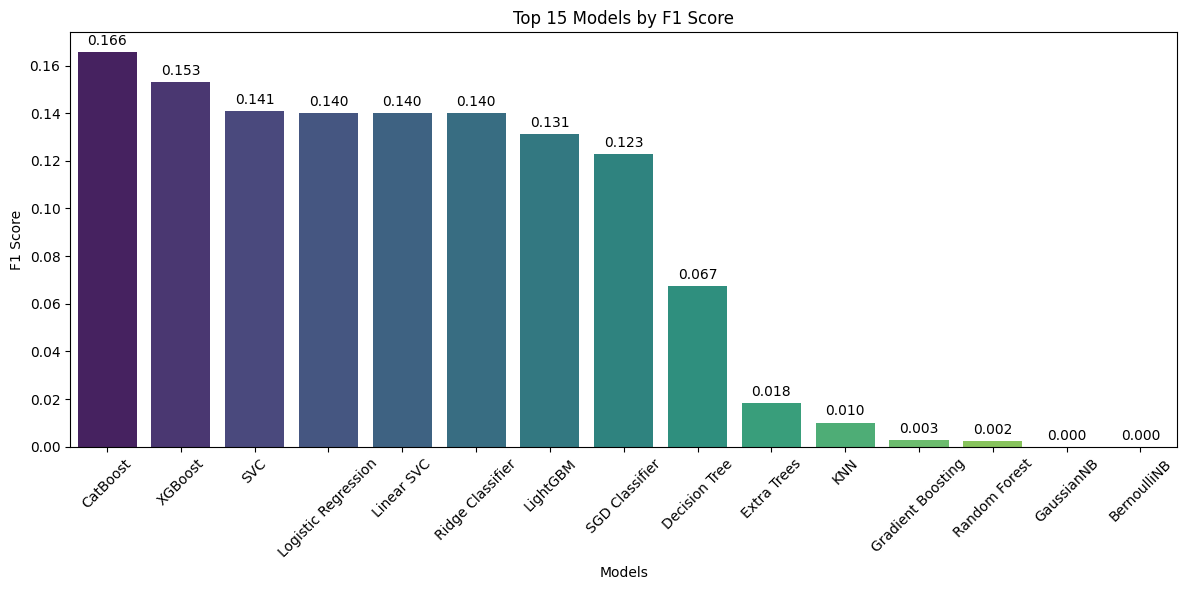

In [8]:
mt.plot_metric_comparison(results, metric='F1 Score')

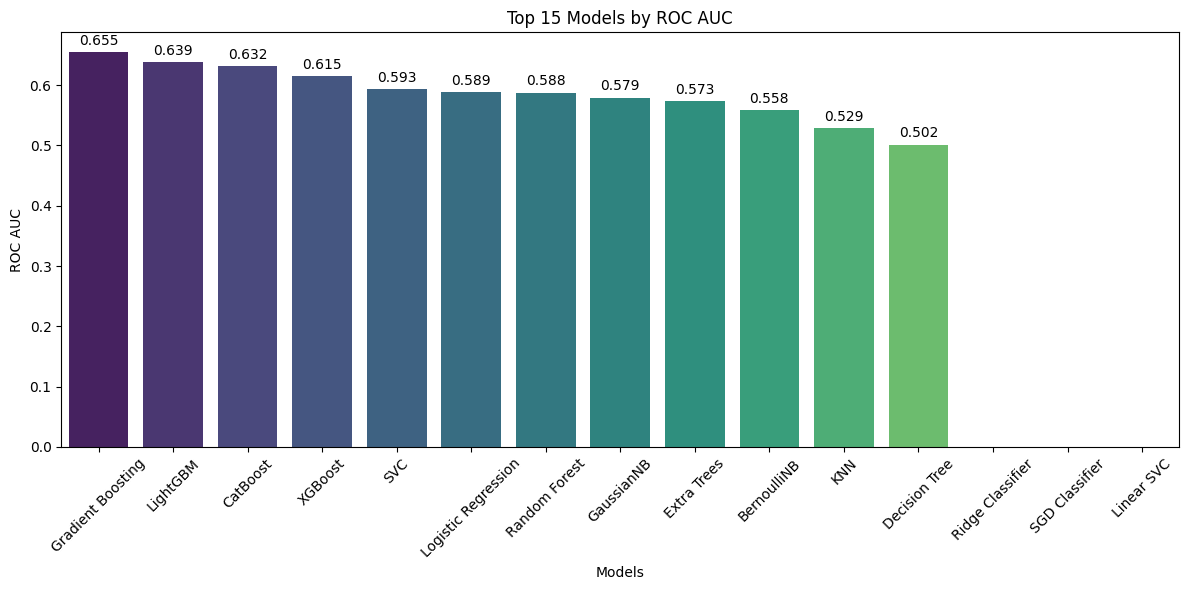

In [9]:
mt.plot_metric_comparison(results, metric='ROC AUC')

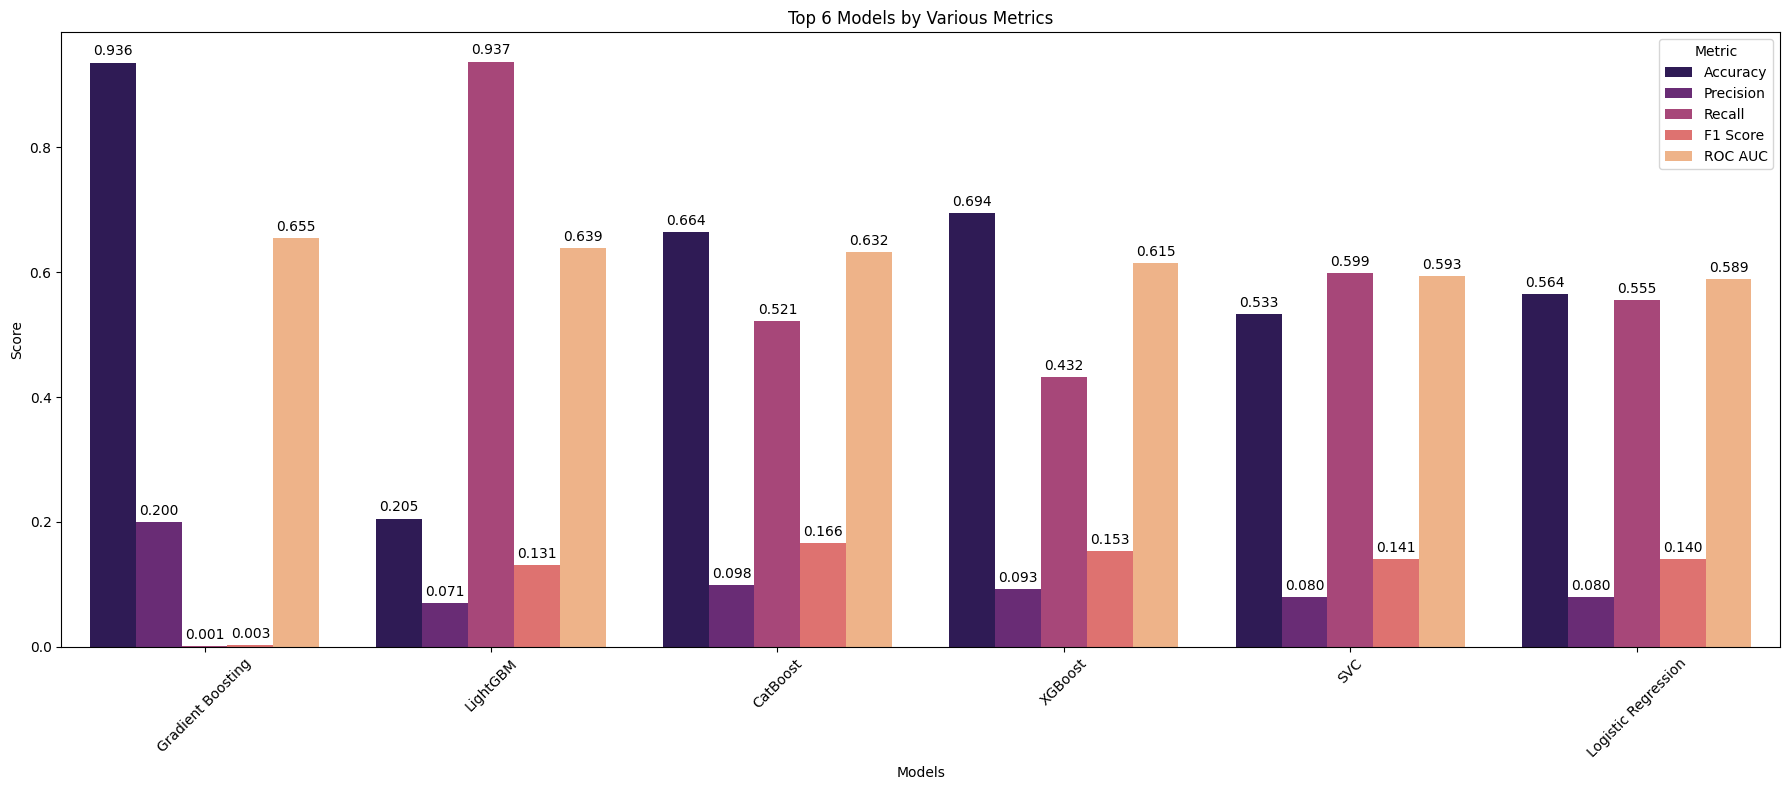

In [10]:

mt.plot_metric_comparison_all(results)

## 7. 🌈 ROC Curves for Best Classifiers

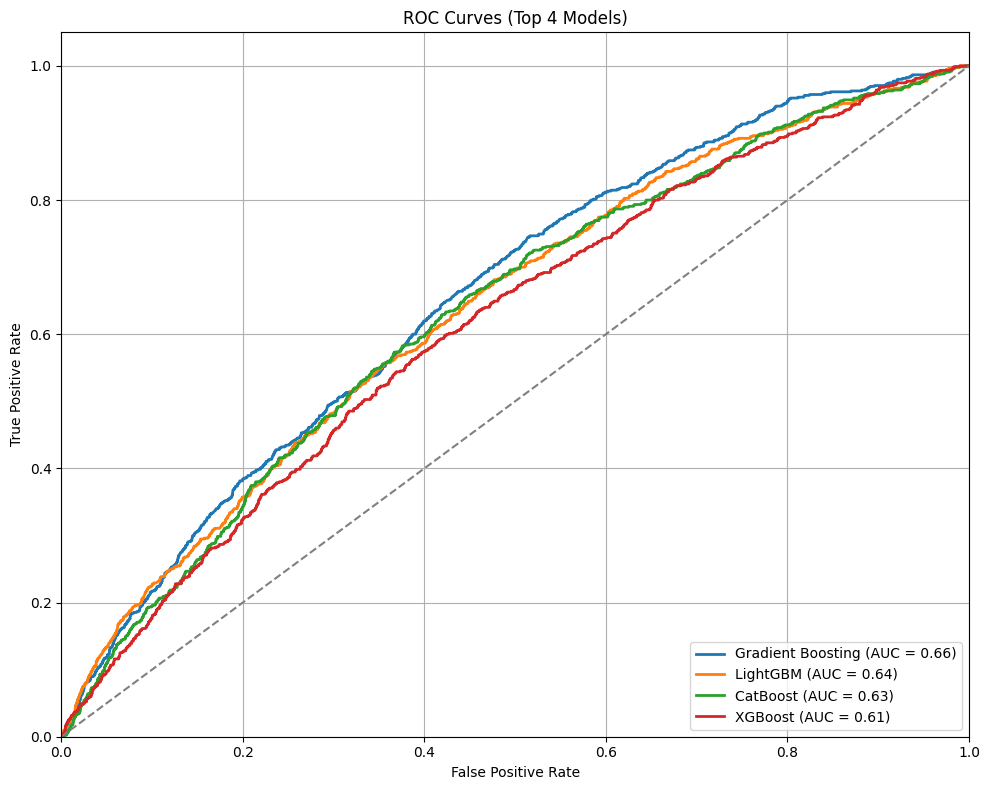

In [11]:
# Ensure models are already trained
mt.plot_roc_curves(models, X_val, y_val, top_n=4)

## 8. 🔎 precision recall Curve

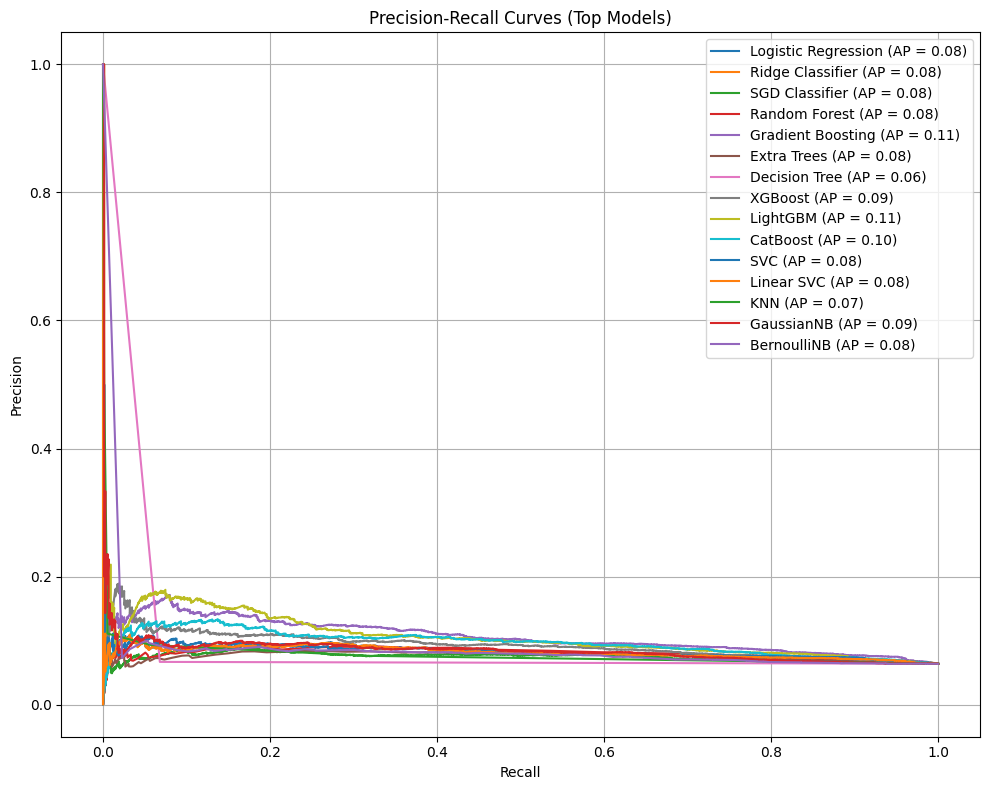

In [12]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_val)
    else:
        continue

    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    ap = average_precision_score(y_val, y_scores)

    plt.plot(recall, precision, label=f"{name} (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Top Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 9. 🔽Save the best Model

In [13]:
mt.save_top_models(results, models, X_train, X_val, y_train, y_val, top_n=4, metric='ROC AUC')

Training and saving model: Gradient Boosting
Training and saving model: LightGBM
[LightGBM] [Info] Number of positive: 3748, number of negative: 54844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 58592, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training and saving model: CatBoost
Training and saving model: XGBoost


LightGBM was observed to have extremely high recall, but its precision was very low, resulting in many false positives. A good balance of recall, F1-score, and ROC AUC was shown by both CatBoost and SGDBoost. However, since CatBoost is designed to work best with raw categorical data, and label encoding had already been applied to the dataset, XGBoost was considered the most suitable and effective model for this case.